In [3]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix

import sys
sys.path.insert(0, '/home/amonell/piloting/scvi-tools/src')
print("Added to path:", sys.path[0])

import scvi.external.resolvi as RESOLVI
import scvi
print("Importing from:", scvi.external.resolvi.__file__)

Added to path: /home/amonell/piloting/scvi-tools/src
Importing from: /home/amonell/piloting/scvi-tools/src/scvi/external/resolvi/__init__.py


In [4]:

path_to_reference_adata = (
    "/mnt/sata4/Alex_Xenium_Data/Perturb8/SI/combined/guides_assigned.h5ad"
)
perturbation_key = "guide_rnas"
background_label = "Other cells"
spatial_embedding_key = "X_cellcharter"

query_adata = sc.read(path_to_reference_adata)

RESOLVI.RESOLVI.setup_anndata(
    query_adata,
    labels_key="resolvi_predicted",
    layer="counts",
    batch_key="batch",
    perturbation_key=perturbation_key,
    control_perturbation="sgCd19",
    background_key=perturbation_key,
    background_category=background_label,
    spatial_embedding_key=spatial_embedding_key,
)

model = RESOLVI.RESOLVI(
    query_adata,
    semisupervised=True,
    mixture_k=1,
    n_latent=10,
    override_mixture_k_in_semisupervised=False,
    control_penalty_weight=10000000,
)

priors = model.compute_dataset_dependent_priors()
print(priors)

model.module.guide.downsample_counts_mean = float(
    model.module.guide.downsample_counts_mean
)
model.module.guide.downsample_counts_std = float(
    model.module.guide.downsample_counts_std
)
model.train(
    max_epochs=300,
    check_val_every_n_epoch=1,
    log_every_n_steps=1,
    lr=3e-4,
    train_on_perturbed_only=True,
)

non_background_mask = query_adata.obs[perturbation_key] != background_label

model.store_denoised_layers(
    query_adata,
    control_layer="resolvi_expression_no_shift",
    perturbed_layer="resolvi_expression_with_shift",
    indices=np.where(non_background_mask)[0],
    n_samples=1000,
    batch_size=256,
)

model.compute_and_store_raw_shifts(
    query_adata,
    control_layer="resolvi_expression_no_shift",
    perturbed_layer="resolvi_expression_with_shift",
    shift_layer="resolvi_raw_shifts",
    mask=non_background_mask,
)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'background_ratio': 0.0012679428, 'median_distance': 328.78759765625, 'mean_log_counts': 4.919981, 'std_log_counts': 0.8017918}
Training configuration with train_on_perturbed_only=True:
  Training set: 2211 perturbation-relevant cells (0.2%)
    - Control cells: 505 (0.1%)
    - Perturbed cells: 1706 (0.2%)
  Excluded from training: 1000530 background cells (99.8%)
  Background/neighbor computations: all 1002741 cells


/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [6]:
model.compute_and_store_umap(
    query_adata,
    layer="resolvi_expression_with_shift",
    basis_key="X_resolvi_with_shift_umap",
)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:

model.compute_and_store_umap(
    query_adata,
    layer="resolvi_expression_no_shift",
    basis_key="X_resolvi_no_shift_umap",
)



ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
genes_for_view = ["guide_rnas", "Klf2", "Perturbation_10", "Perturbation_4"]
model.plot_resolvi_umap(
    query_adata,
    basis_key="X_resolvi_no_shift_umap",
    color=genes_for_view,
    layer="resolvi_expression_no_shift",
    ncols=2,
)
model.plot_resolvi_umap(
    query_adata,
    basis_key="X_resolvi_with_shift_umap",
    color=genes_for_view,
    layer="resolvi_expression_with_shift",
    ncols=2,
)


<Axes: title={'center': 'Volcano Plot: Shifts vs Log Mean Counts'}, xlabel='Log Mean Counts', ylabel='Shift'>

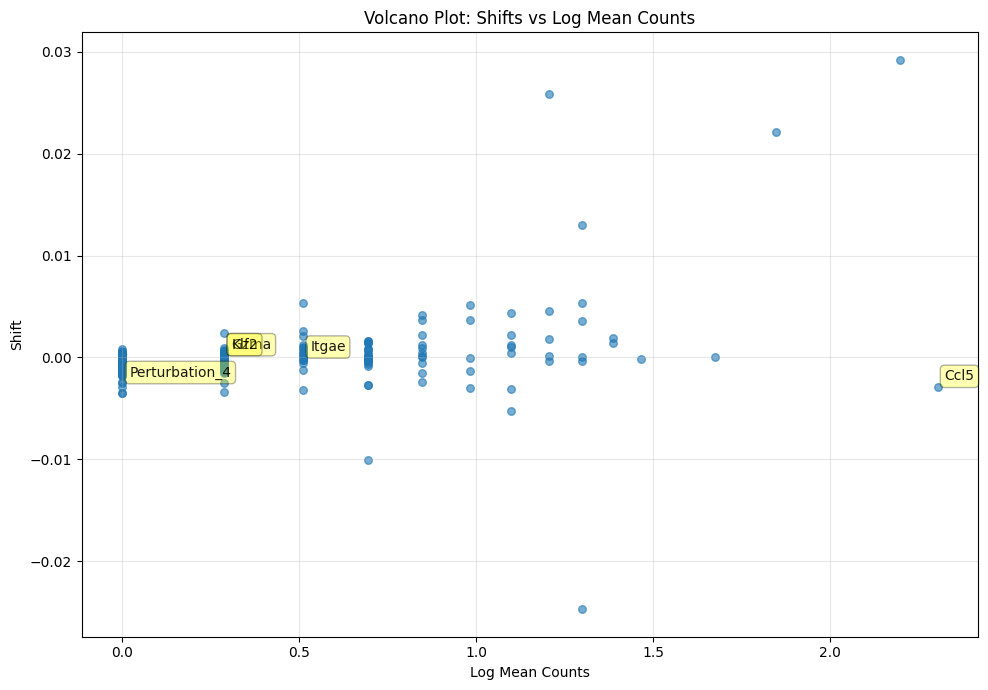

In [11]:


    target_gene = "Cd69"
    cluster_cellcharter = 0
    target_mask = (query_adata.obs[perturbation_key] == f"sg{target_gene}") & (
        query_adata.obs["cluster_cellcharter"] == cluster_cellcharter
    )

    model.compute_shift_outputs_obsm(
        query_adata,
        obsm_key="resolvi_shift_outputs",
        perturbation_value=f"sg{target_gene}",
        perturbation_key=perturbation_key,
        batch_size=256,
    )

    model.plot_shift_volcano(
        query_adata,
        shift_layer="resolvi_raw_shifts",
        count_layer="counts",
        genes_to_highlight=["Itgae", "Gzma", "Perturbation_4", "Klf2", "Ccl5"],
        mask=target_mask,
        title="Volcano Plot: Shifts vs Log Mean Counts",
    )
